In [446]:
#!/usr/bin/env python3

import sys
import heapq
import numpy as np
from copy import copy
import timeit

import pandas as pd
from sklearn import tree, metrics


# sys.setrecursionlimit(sys.maxunicode)


class Spade:

    def __init__(self, pos_filepath, neg_filepath, k):

        self.pos_transactions, self.P = spade_repr_from_transaction(get_transactions(pos_filepath))
        self.pos_transactions_repr = self.pos_transactions['repr']
        self.pos_transactions_cover = self.pos_transactions['covers']

        self.neg_transactions, self.N = spade_repr_from_transaction(get_transactions(neg_filepath), self.P)
        self.neg_transactions_repr = self.neg_transactions['repr']
        self.neg_transactions_cover = self.neg_transactions['covers']

        self.k = k
        self.top_k_patterns = None

    def min_top_k(self, criterion_is_wracc=False):

        k = self.k
        D = self.pos_transactions_repr.copy()

        for j, transaction in self.neg_transactions_repr.items():
            try:
                D[j].update(transaction)
            except:
                D[j] = transaction

        heap_best_values = []
        dictionnary_best_sequences = {}
        P = {}

        heapq.heapify(heap_best_values)
        min_support = 1

        if criterion_is_wracc:
            for sequence in D:
                nb_pos = self.P
                nb_neg = self.N
                wracc = weighted_relative_accuracy(nb_pos, nb_neg, D[sequence])
                if wracc in dictionnary_best_sequences:
                    dictionnary_best_sequences[wracc].append((wracc, sequence, D[sequence]))
                else:
                    heapq.heappush(heap_best_values, wracc)
                    dictionnary_best_sequences[wracc] = []
                    dictionnary_best_sequences[wracc].append((wracc, sequence, D[sequence]))
                P[sequence] = D[sequence]


        else:
            for sequence in D:
                support = len(D[sequence])
                if support in dictionnary_best_sequences:
                    dictionnary_best_sequences[support].append((support, sequence, D[sequence]))
                else:
                    heapq.heappush(heap_best_values, support)
                    dictionnary_best_sequences[support] = []
                    dictionnary_best_sequences[support].append((support, sequence, D[sequence]))
                P[sequence] = D[sequence]

        remove_unfrequent(k, heap_best_values, dictionnary_best_sequences)

        if criterion_is_wracc:
            if len(heap_best_values) < k:
                min_positive_support = 0
                min_wracc = -np.inf
            else:
                min_wracc = heap_best_values[0]
                min_positive_support = get_min_positive_support(min_wracc, nb_pos, nb_neg)
            get_best_wrack_sequences(P, k, nb_pos, nb_neg, min_positive_support, min_wracc, heap_best_values,
                                     dictionnary_best_sequences)

        else:
            if len(heap_best_values) < k:
                min_support = 1
            else:
                min_support = heap_best_values[0]
            get_frequent_sequences(P, k, min_support, heap_best_values, dictionnary_best_sequences)

        elements = []
        for j in range(len(heap_best_values)):
            value = heapq.heappop(heap_best_values)
            for element in dictionnary_best_sequences[value]:
                elements.append(element)

        # for i in elements:
        #     print(f"{round(i[0], 3)}, {i[1]}")

        # -> return un tuple, le premier element ce sera tj {"nom_pattern":{transactions_id}}, le deuxième élément ce sera nb transaction positive
        return ({j[1]: set(j[2].keys()) for j in elements}, self.P, self.N)

    def convert_dict_to_np_array(self, patterns_in_trans):
        """
        Convert a dictionary of patterns to a NumPy array where each row represents a transaction and each column represents a pattern.
        """

        # Get all unique transactions
        all_transactions = set()
        for transactions in patterns_in_trans.values():
            all_transactions.update(transactions)

        # Create an empty NumPy array with dimensions (number of transactions, number of unique patterns)
        num_transactions = self.P + self.N
        num_patterns = len(patterns_in_trans)
        np_array = np.zeros((num_transactions, num_patterns))

        # Create a mapping from pattern to column index in the array
        pattern_to_col_index = {pattern: i for i, pattern in enumerate(patterns_in_trans.keys())}

        # Iterate over each pattern and its associated transactions
        for pattern, transactions in patterns_in_trans.items():
            col_index = pattern_to_col_index[pattern]
            for transaction in transactions:
                row_index = list(all_transactions).index(transaction)
                np_array[row_index, col_index] = 1

        return np_array

    def get_feature_matrices(self, best_patterns, train_set_ids):
        """
        Assuming we know the top-k best patterns and the presence of each of them in the transactions (self.pos_features_matrix and self.neg_features_matrix).
        This method should return the feature matrices and the labels for the training and testing sets w.r.t the ids of the transactions in the training set.
        """

        # Convert the self.pos_patterns_in_trans and self.pos_patterns_in_trans into numpy arrays
        feat_matrix = self.convert_dict_to_np_array(best_patterns)

        # Input Matrices
        train_matrix = feat_matrix[train_set_ids]
        test_matrix = np.delete(feat_matrix, train_set_ids, axis=0)

        # Output Labels
        train_nb_pos_label = np.sum(train_set_ids < self.P)
        train_nb_neg_label = np.sum(train_set_ids >= self.P)
        train_labels = np.concatenate((np.ones(train_nb_pos_label), np.zeros(train_nb_neg_label)))
        test_labels = np.concatenate((np.ones(self.P - train_nb_pos_label), np.zeros(self.N - train_nb_neg_label)))

        return {
            'train_matrix': train_matrix,
            'test_matrix': test_matrix,
            'train_labels': train_labels,
            'test_labels': test_labels,
        }

    def cross_validation(self, nfolds, wracc=False, best_patterns=None):
        accuracy = []

        pos_fold_size = self.P // nfolds
        neg_fold_size = self.N // nfolds
        for fold in range(nfolds):
            print('fold {}'.format(fold + 1))
            pos_train_set_ids = np.array([i for i in range(self.P) if
                                 i < fold * pos_fold_size or i >= (fold + 1) * pos_fold_size])
            neg_train_set_ids = np.array([self.P + i for i in range(self.N) if
                                 i < fold * neg_fold_size or i >= (fold + 1) * neg_fold_size])
            train_set_ids = np.concatenate((pos_train_set_ids, neg_train_set_ids))


            if best_patterns is None:
                self.top_k_patterns = self.min_top_k(wracc)[0]
                m = self.get_feature_matrices(self.top_k_patterns, train_set_ids)
            else:
                m = self.get_feature_matrices(best_patterns, train_set_ids)

            classifier = tree.DecisionTreeClassifier(random_state=1)
            classifier.fit(m['train_matrix'], m['train_labels'])
            #print(classifier.feature_importances_)

            predicted = classifier.predict(m['test_matrix'])
            accuracy.append(metrics.accuracy_score(m['test_labels'], predicted))
            print(f'Accuracy: {accuracy[-1]}')

        return accuracy



def get_transactions(filepath):
    transactions = []
    with open(filepath) as f:
        new_transaction = True
        for line in f:
            if line.strip():
                if new_transaction:
                    transactions.append([])
                    new_transaction = False
                element = line.split(" ")
                assert (int(element[1]) - 1 == len(transactions[-1]))
                transactions[-1].append(element[0])
            else:
                new_transaction = True
    return transactions


def spade_repr_from_transaction(transactions, min_id=0):
    spade_repr = {}
    covers = {}
    for tid, transaction in enumerate(transactions):
        tid += min_id
        for i, item in enumerate(transaction):
            try:
                covers[item].add(tid)
            except KeyError:
                covers[item] = {tid}
            try:
                spade_repr[item][tid].append(i)
            except KeyError:
                try:
                    spade_repr[item][tid] = [i]
                except KeyError:
                    spade_repr[item] = {tid: [i]}

    return {'repr': spade_repr, 'covers': covers}, tid - min_id + 1


def remove_unfrequent(k: int, heap_best_values: list, dictionnary_best_sequences: dict):
    # calculate how many sequences are in excess, if there are not we don't have unfrequent
    nb_exces_sequences = len(heap_best_values) - k if len(heap_best_values) - k > 0 else 0
    if nb_exces_sequences == 0: return

    excess_list = []

    # take n+1 best elements, and remove elements with value strictly inferior to the last best sequence
    while nb_exces_sequences > 0:
        excess_list.append(heapq.heappop(heap_best_values))
        nb_exces_sequences -= 1

    for value in excess_list:
        dictionnary_best_sequences.pop(value)


def get_frequent_sequences(P, top_k, min_support, heap_best_frequencies, dictionnary_most_frequent_sequences):
    for ra in P:
        if len(P[ra]) < min_support:
            continue
        Pa = {}
        for rb in P:
            if len(P[rb]) < min_support or len(P[ra]) < min_support:
                continue
            rab, P_rab = intersect(ra, rb, P)
            support_rab = len(P_rab)
            if support_rab >= min_support:
                if support_rab in dictionnary_most_frequent_sequences:
                    dictionnary_most_frequent_sequences[support_rab].append((support_rab, rab, P_rab))
                else:
                    heapq.heappush(heap_best_frequencies, support_rab)
                    dictionnary_most_frequent_sequences[support_rab] = []
                    dictionnary_most_frequent_sequences[support_rab].append((support_rab, rab, P_rab))
                Pa[rab] = P_rab
        if Pa:
            # remove elements that became unfrequent
            remove_unfrequent(top_k, heap_best_frequencies, dictionnary_most_frequent_sequences)

            # update min_support after removind unfrequent
            if len(heap_best_frequencies) < top_k:
                min_support = 1
            else:
                min_support = heap_best_frequencies[0]

            if Pa:
                get_frequent_sequences(Pa, top_k, min_support, heap_best_frequencies,
                                       dictionnary_most_frequent_sequences)
                # update min_support after recursive call
                if len(heap_best_frequencies) < top_k:
                    min_support = 1
                else:
                    min_support = heap_best_frequencies[0]

    return heap_best_frequencies, dictionnary_most_frequent_sequences


def get_best_wrack_sequences(P, top_k, nb_pos, nb_neg, min_positive_support, min_wracc, heap_best_values,
                             dictionnary_best_sequences):
    for ra in P:
        ra_pos_support = get_positive_support(nb_pos, P[ra])
        if ra_pos_support < min_positive_support:
            continue

        Pa = {}
        for rb in P:
            ra_pos_support = get_positive_support(nb_pos, P[ra])
            rb_pos_support = get_positive_support(nb_pos, P[rb])
            if ra_pos_support < min_positive_support or rb_pos_support < min_positive_support:
                continue

            rab, P_rab = intersect(ra, rb, P)

            if len(P_rab) >= 1:
                pos_support = get_positive_support(nb_pos, P_rab)
                if pos_support >= min_positive_support:
                    wracc = weighted_relative_accuracy(nb_pos, nb_neg, P_rab)
                    if wracc >= min_wracc:

                        if wracc in dictionnary_best_sequences:
                            dictionnary_best_sequences[wracc].append((wracc, rab, P_rab))
                        else:
                            heapq.heappush(heap_best_values, wracc)
                            dictionnary_best_sequences[wracc] = []
                            dictionnary_best_sequences[wracc].append((wracc, rab, P_rab))
                    Pa[rab] = P_rab
        if Pa:
            # remove elements that became unfrequent
            remove_unfrequent(top_k, heap_best_values, dictionnary_best_sequences)

            # update min_support after removind unfrequent
            if len(heap_best_values) < top_k:
                min_positive_support = 0
            else:
                min_wracc = heap_best_values[0]
                min_positive_support = get_min_positive_support(min_wracc, nb_pos, nb_neg)

            if Pa:
                get_best_wrack_sequences(Pa, top_k, nb_pos, nb_neg, min_positive_support, min_wracc, heap_best_values,
                                         dictionnary_best_sequences)
                # update min_support after recursive call
                if len(heap_best_values) < top_k:
                    min_positive_support = 0
                else:
                    min_wracc = heap_best_values[0]
                    min_positive_support = get_min_positive_support(min_wracc, nb_pos, nb_neg)
    return heap_best_values, dictionnary_best_sequences


def intersect(ra, rb, P):
    rab = ra + "-" + rb.split("-")[-1]
    # rab = ra+rb[-1]
    transaction_in_common_ids = P[ra].keys() & P[rb].keys()
    P_rab = {}
    for t_id in transaction_in_common_ids:
        pos_a = P[ra][t_id][0]
        position_list_ab = [pos_b for pos_b in P[rb][t_id] if pos_b > pos_a]
        if position_list_ab:
            P_rab[t_id] = position_list_ab

    return rab, P_rab


def get_min_positive_support(min_Wracc, nb_pos, nb_neg):
    return (((nb_pos + nb_neg) ** 2) / nb_neg) * min_Wracc


def get_positive_support(P, transactions_containing_pattern):
    return sum([i < P for i in transactions_containing_pattern])


def weighted_relative_accuracy(nb_pos, nb_neg, transactions_containing_pattern):
    p = sum([i < nb_pos for i in transactions_containing_pattern])
    n = len(transactions_containing_pattern) - p
    # print(P)
    # print(N)
    return (nb_pos / (nb_pos + nb_neg)) * (nb_neg / (nb_pos + nb_neg)) * (p / nb_pos - n / nb_neg)




def main():
    #pos_filepath = sys.argv[1]  # filepath to positive class file
    #neg_filepath = sys.argv[2]  # filepath to negative class file
    #k = int(sys.argv[3])

    # pos_filepath = "datasets/Protein/PKA_group15.txt"
    # neg_filepath = "datasets/Protein/SRC1521.txt"

    pos_filepath = "datasets/Test/positive.txt"
    neg_filepath = "datasets/Test/negative.txt"
    k = 5

    wrack = True

    # Create the object
    a = timeit.default_timer()
    s = Spade(pos_filepath, neg_filepath, k)
    sol = s.min_top_k(wrack)
    print(sol[0])
    b = timeit.default_timer()
    # print(b-a)




# Spade and supervised algo

In [530]:

pos_filepath = "datasets/Protein/PKA_group15.txt"
neg_filepath = "datasets/Protein/SRC1521.txt"



# Create the object
k = 40
s = Spade(pos_filepath, neg_filepath, k)


In [531]:
sol = s.min_top_k(True)
sol[0].keys()

dict_keys(['R-S-D', 'R-V', 'K-S', 'R-R-S-G', 'S-R-R', 'R-S-V', 'R-R-S-E', 'R-T', 'R-K', 'R-R-R-S', 'A-R-S', 'R-S-T', 'R-S-G', 'K-R', 'R-R-S-V', 'R-R-A', 'R-R-S-A', 'K-R-S', 'R-A', 'R-R-V', 'R-R-S-L', 'R-R-T', 'R-R-E', 'S-R-S', 'S', 'R-S-E', 'S-S', 'R-R-L', 'R-R-S-S', 'R-S-R', 'R-R-R', 'R-S-A', 'S-R', 'R-L', 'R-S-L', 'R-S-S', 'R', 'R-R', 'R-R-S', 'R-S'])

In [532]:
accuracy = s.cross_validation(5, wracc=False)

fold 1
Accuracy: 0.8623188405797102
fold 2
Accuracy: 0.9057971014492754
fold 3
Accuracy: 0.8913043478260869
fold 4
Accuracy: 0.9057971014492754
fold 5
Accuracy: 0.8913043478260869


## Accuracy as a function of k

Spade

In [533]:
spade_acc_by_k = pd.DataFrame(columns=['k', 'mean_accuracy', 'std_accuracy'])

spade_accuracy = s.cross_validation(5, wracc=False)
spade_acc_by_k.loc[0] = [len(s.top_k_patterns), np.mean(spade_accuracy), np.std(spade_accuracy)]
print(f"Accuracy for k={len(s.top_k_patterns)}: {np.mean(spade_accuracy)}")
print("====================================")

remaining_patterns = copy(s.top_k_patterns)
for i in range(len(s.top_k_patterns)-1):
    remaining_patterns.pop(list(remaining_patterns.keys())[0])

    spade_accuracy = s.cross_validation(5, best_patterns=remaining_patterns)
    spade_acc_by_k.loc[i+1] = [len(s.top_k_patterns)-i-1, np.mean(spade_accuracy), np.std(spade_accuracy)]

    print(f"Accuracy for k={len(s.top_k_patterns)-i-1}: {np.mean(spade_accuracy)}")

fold 1
Accuracy: 0.8623188405797102
fold 2
Accuracy: 0.9057971014492754
fold 3
Accuracy: 0.8913043478260869
fold 4
Accuracy: 0.9057971014492754
fold 5
Accuracy: 0.8913043478260869
Accuracy for k=47: 0.8913043478260869
fold 1
Accuracy: 0.9057971014492754
fold 2
Accuracy: 0.8695652173913043
fold 3
Accuracy: 0.8913043478260869
fold 4
Accuracy: 0.927536231884058
fold 5
Accuracy: 0.927536231884058
Accuracy for k=46: 0.9043478260869564
fold 1
Accuracy: 0.8840579710144928
fold 2
Accuracy: 0.8840579710144928
fold 3
Accuracy: 0.8768115942028986
fold 4
Accuracy: 0.9130434782608695
fold 5
Accuracy: 0.9202898550724637
Accuracy for k=45: 0.8956521739130435
fold 1
Accuracy: 0.9130434782608695
fold 2
Accuracy: 0.9057971014492754
fold 3
Accuracy: 0.8985507246376812
fold 4
Accuracy: 0.9420289855072463
fold 5
Accuracy: 0.9202898550724637
Accuracy for k=44: 0.9159420289855073
fold 1
Accuracy: 0.9202898550724637
fold 2
Accuracy: 0.9057971014492754
fold 3
Accuracy: 0.8985507246376812
fold 4
Accuracy: 0.920

Supervised algorithm

In [534]:
supervised_acc_by_k = pd.DataFrame(columns=['k', 'mean_accuracy', 'std_accuracy'])

supervised_accuracy = s.cross_validation(5, wracc=True)
supervised_acc_by_k.loc[0] = [len(s.top_k_patterns), np.mean(supervised_accuracy), np.std(supervised_accuracy)]
print(f"Accuracy for k={len(s.top_k_patterns)}: {np.mean(supervised_accuracy)}")
print("====================================")

remaining_patterns = copy(s.top_k_patterns)
for i in range(len(s.top_k_patterns)-1):
    remaining_patterns.pop(list(remaining_patterns.keys())[0])

    supervised_accuracy = s.cross_validation(5, best_patterns=remaining_patterns)
    supervised_acc_by_k.loc[i+1] = [len(s.top_k_patterns)-i-1, np.mean(supervised_accuracy), np.std(supervised_accuracy)]

    print(f"Accuracy for k={len(s.top_k_patterns)-i-1}: {np.mean(supervised_accuracy)}")
    print("====================================")




fold 1
Accuracy: 0.782608695652174
fold 2
Accuracy: 0.8260869565217391
fold 3
Accuracy: 0.8405797101449275
fold 4
Accuracy: 0.7753623188405797
fold 5
Accuracy: 0.9202898550724637
Accuracy for k=40: 0.8289855072463768
fold 1
Accuracy: 0.8043478260869565
fold 2
Accuracy: 0.8260869565217391
fold 3
Accuracy: 0.8623188405797102
fold 4
Accuracy: 0.782608695652174
fold 5
Accuracy: 0.8985507246376812
Accuracy for k=39: 0.8347826086956524
fold 1
Accuracy: 0.7608695652173914
fold 2
Accuracy: 0.8043478260869565
fold 3
Accuracy: 0.8405797101449275
fold 4
Accuracy: 0.7898550724637681
fold 5
Accuracy: 0.9057971014492754
Accuracy for k=38: 0.8202898550724637
fold 1
Accuracy: 0.7463768115942029
fold 2
Accuracy: 0.8260869565217391
fold 3
Accuracy: 0.8623188405797102
fold 4
Accuracy: 0.782608695652174
fold 5
Accuracy: 0.9202898550724637
Accuracy for k=37: 0.827536231884058
fold 1
Accuracy: 0.782608695652174
fold 2
Accuracy: 0.8405797101449275
fold 3
Accuracy: 0.8695652173913043
fold 4
Accuracy: 0.797101

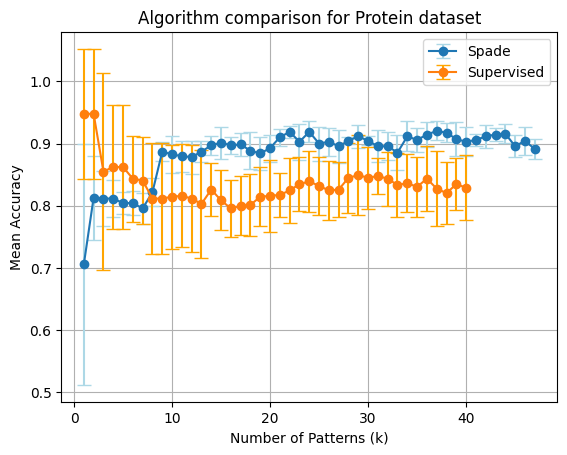

In [535]:
import matplotlib.pyplot as plt


# Extract data from DataFrame
spade_k_values = spade_acc_by_k['k']
spade_mean_accuracy_values = spade_acc_by_k['mean_accuracy']
spade_std_accuracy_values = spade_acc_by_k['std_accuracy']

supervised_k_values = supervised_acc_by_k['k']
supervised_mean_accuracy_values = supervised_acc_by_k['mean_accuracy']
supervised_std_accuracy_values = supervised_acc_by_k['std_accuracy']



# Plot accuracy as a function of k with error bars
plt.errorbar(spade_k_values, spade_mean_accuracy_values, yerr=spade_std_accuracy_values, fmt='o-', ecolor='lightblue', capsize=5, label='Spade')
plt.errorbar(supervised_k_values, supervised_mean_accuracy_values, yerr=supervised_std_accuracy_values, fmt='o-', ecolor='orange', capsize=5,  label='Supervised')

plt.title('Algorithm comparison for Protein dataset')
plt.xlabel('Number of Patterns (k)')
plt.ylabel('Mean Accuracy')
plt.legend()
plt.grid(True)
plt.savefig("Protein_dataset_accuracy.png")
plt.show()



## Discrimative power of the patterns for the Spade algorithm

In [527]:


print(f"Percentage of positive transactions in the dataset: {np.round(s.P/(s.P+s.N), 3)}")
for patt in s.top_k_patterns:
    print("====================================")
    print(f"Pattern '{patt}' is present in {len(s.top_k_patterns[patt])} transactions")
    perc_of_pos = np.round(np.sum([(i<s.P) for i in s.top_k_patterns[patt]])/len(s.top_k_patterns[patt]), 3)
    perc_of_neg = np.round(1 - perc_of_pos, 3)
    print(f"Percentage of positive transactions containing the pattern {patt}: {perc_of_pos:.2%}")
    print(f"Percentage of negative transactions containing the pattern {patt}: {perc_of_neg:.2%}")




Percentage of positive transactions in the dataset: 0.358
Pattern 'and-for-reuter' is present in 567 transactions
Percentage of positive transactions containing the pattern and-for-reuter: 56.40%
Percentage of negative transactions containing the pattern and-for-reuter: 43.60%
Pattern 'for-compani' is present in 440 transactions
Percentage of positive transactions containing the pattern for-compani: 62.50%
Percentage of negative transactions containing the pattern for-compani: 37.50%
Pattern 'acquir-and' is present in 206 transactions
Percentage of positive transactions containing the pattern acquir-and: 93.20%
Percentage of negative transactions containing the pattern acquir-and: 6.80%
Pattern 'that' is present in 345 transactions
Percentage of positive transactions containing the pattern that: 70.70%
Percentage of negative transactions containing the pattern that: 29.30%
Pattern 'inc-for-reuter' is present in 469 transactions
Percentage of positive transactions containing the pattern

In [445]:
s.top_k_patterns

# No Mining (only single symbols)

In [135]:

# Create the object
k = 1
s = Spade(pos_filepath, neg_filepath, k)


transactions_cover = s.pos_transactions_cover.copy()

for patt in s.pos_transactions_cover:
    if patt in s.neg_transactions_cover:
        transactions_cover[patt] = (s.pos_transactions_cover[patt] | s.neg_transactions_cover[patt])

for patt in s.neg_transactions_cover:
    if patt not in s.pos_transactions_cover:
        transactions_cover[patt] = s.neg_transactions_cover[patt]

accuracy = s.cross_validation(5, best_patterns=transactions_cover)



fold 1
Accuracy: 0.8768115942028986
fold 2
Accuracy: 0.8840579710144928
fold 3
Accuracy: 0.8478260869565217
fold 4
Accuracy: 0.8913043478260869
fold 5
Accuracy: 0.8623188405797102


In [136]:
transactions_cover.keys()

dict_keys(['W', 'K', 'A', 'L', 'R', 'F', 'S', 'T', 'M', 'D', 'G', 'N', 'E', 'V', 'H', 'I', 'C', 'Y', 'P', 'Q'])

## Discrimative power of the patterns for the single symbol

In [137]:
print(f"Percentage of positive transactions in the dataset: {np.round(s.P/(s.P+s.N), 3)}")
for patt in transactions_cover:
    print("====================================")
    print(f"Pattern '{patt}' is present in {len(transactions_cover[patt])} transactions")

    wra = weighted_relative_accuracy(s.P, s.N, transactions_cover[patt])
    print(f"Weighted Relative Accuracy: {wra}")
    perc_of_pos = np.sum([(i<s.P) for i in transactions_cover[patt]])/len(transactions_cover[patt])
    perc_of_neg = 1 - perc_of_pos
    print(f"--> Percentage of positive transactions containing the pattern '{patt}': {perc_of_pos:.2%}")
    print(f"--> Percentage of negative transactions containing the pattern '{patt}': {perc_of_neg:.2%}")



Percentage of positive transactions in the dataset: 0.548
Pattern 'W' is present in 77 transactions
Weighted Relative Accuracy: -0.013253972361679
--> Percentage of positive transactions containing the pattern 'W': 42.86%
--> Percentage of negative transactions containing the pattern 'W': 57.14%
Pattern 'K' is present in 379 transactions
Weighted Relative Accuracy: 0.017599503131307915
--> Percentage of positive transactions containing the pattern 'K': 58.05%
--> Percentage of negative transactions containing the pattern 'K': 41.95%
Pattern 'A' is present in 442 transactions
Weighted Relative Accuracy: 0.0009999482428445748
--> Percentage of positive transactions containing the pattern 'A': 54.98%
--> Percentage of negative transactions containing the pattern 'A': 45.02%
Pattern 'L' is present in 461 transactions
Weighted Relative Accuracy: 0.0018404844469747936
--> Percentage of positive transactions containing the pattern 'L': 55.10%
--> Percentage of negative transactions containing

# Sequential Covering Algorithm

In [417]:
def calculate_gini_index(class_counts):
    """
    Calculate the Gini index for a group based on class counts.

    Parameters:
    - class_counts: A list or tuple containing counts of positive and negative instances, e.g., [positive_count, negative_count].

    Returns:
    - gini_index: The computed Gini index value for the group.
    """
    total_count = sum(class_counts)
    if total_count == 0:
        return 0.0

    p_positive = class_counts[0] / total_count
    p_negative = class_counts[1] / total_count

    gini_index = 1 - (p_positive**2 + p_negative**2)
    return gini_index

def compute_gini_index(group_A, group_B):
    """
    Compute the weighted average Gini index for two groups.

    Parameters:
    - group_A: A list or tuple containing counts of positive and negative instances for group A.
    - group_B: A list or tuple containing counts of positive and negative instances for group B.

    Returns:
    - weighted_gini_index: The weighted average Gini index value for the two groups.
    """
    # Calculate Gini index for group A
    gini_A = calculate_gini_index(group_A)

    # Calculate Gini index for group B
    gini_B = calculate_gini_index(group_B)

    # Calculate the total number of instances in both groups
    total_count = sum(group_A) + sum(group_B)

    # Calculate the weighted average Gini index
    weighted_gini_index = (sum(group_A) / total_count) * gini_A + (sum(group_B) / total_count) * gini_B

    return weighted_gini_index

# Example usage:
group_A = [25, 5]  # Counts of positive and negative instances in group A
group_B = [20, 10]  # Counts of positive and negative instances in group B

gini_index = compute_gini_index(group_A, group_B)
gini_index

0.36111111111111105

In [593]:

def remove_covered_transactions(dataset : Spade, pattern_cover, P):
    """
    Remove the transactions covered by the pattern
    :param dataset: Spade object
    :param pattern: pattern
    :return: Spade object
    """
    remaining_transactions = copy(dataset)

    patt_text = list(pattern_cover.keys())[0]
    trans_to_remove = pattern_cover[patt_text]

    # Remove the positive transactions covered by the pattern
    p = sum([trans<P for trans in trans_to_remove])
    n = len(trans_to_remove) - p

    if p>0:
        filtered_pos_transactions_cover = {}
        filtered_pos_transactions_repr = {}
        for key, value in remaining_transactions.pos_transactions_cover.items():
            filtered_trans = value - trans_to_remove

            if filtered_trans:
                filtered_pos_transactions_cover[key] = filtered_trans
                filtered_pos_transactions_repr[key] = {key: value for key, value in remaining_transactions.pos_transactions_repr[key].items()
                                                       if key in filtered_trans}

        remaining_transactions.pos_transactions_cover = filtered_pos_transactions_cover
        remaining_transactions.pos_transactions_repr = filtered_pos_transactions_repr

        # Update the number of transactions
        remaining_transactions.P -= p

    # Remove the negative transactions covered by the pattern
    if n>0:
        filtered_neg_transactions_cover = {}
        filtered_neg_transactions_repr = {}
        for key, value in remaining_transactions.neg_transactions_cover.items():
            filtered_trans = value - trans_to_remove

            if filtered_trans:
                filtered_neg_transactions_cover[key] = filtered_trans
                filtered_neg_transactions_repr[key] = {key: value for key, value in remaining_transactions.neg_transactions_repr[key].items() if key in filtered_trans}

        remaining_transactions.neg_transactions_cover = filtered_neg_transactions_cover
        remaining_transactions.neg_transactions_repr = filtered_neg_transactions_repr

        # Update the number of transactions
        remaining_transactions.N -= n

    return remaining_transactions, int(p > n)




def SequentialCoveringAlgorithm2(dataset : Spade, k):
    """
    Sequential Covering Algorithm
    :param dataset: list of transactions
    :param k: number of patterns to be mined
    :param metric: metric to be used to evaluate the patterns
    :param min_support: minimum support threshold
    :return: list of patterns
    """
    remaining_transactions = dataset

    patterns_rules = {}
    for i in range(k):
        # Find the best pattern
        best_pattern = remaining_transactions.min_top_k(criterion_is_wracc=False)[0]

        patterns_text = list(best_pattern.keys())[0]
        print(patterns_text)

        # Remove the transactions covered by the best pattern and store the rule
        remaining_transactions, patterns_rules[patterns_text] = remove_covered_transactions(remaining_transactions, best_pattern, dataset.P)

        if remaining_transactions.P == 0 and remaining_transactions.N == 0:
            print("No more transactions to mine")
            break

        print(f"Remaining transactions: {remaining_transactions.P} positive and {remaining_transactions.N} negative transactions")


    final_class = 1 if remaining_transactions.P > remaining_transactions.N else 0


    return patterns_rules, final_class

def SequentialCoveringAlgorithm(dataset : Spade, k):
    """
    Sequential Covering Algorithm
    :param dataset: list of transactions
    :param k: number of patterns to be mined
    :param metric: metric to be used to evaluate the patterns
    :param min_support: minimum support threshold
    :return: list of patterns
    """
    remaining_transactions = dataset
    remaining_transactions.k = 10

    patterns_rules = {}
    for i in range(k):
        # Find the best pattern
        best_pattern = remaining_transactions.min_top_k(criterion_is_wracc=False)[0]

        patterns_text = list(best_pattern.keys())[0]

        best_gini_index = ['', 0.5]
        for key in best_pattern.keys():
            # Gini index of the group containing the pattern and the group not containing the pattern
            trans_to_remove = best_pattern[key]
            p = sum([trans<dataset.P for trans in trans_to_remove])
            n = len(trans_to_remove) - p
            group_containing = [p, n]
            group_not_containing = [remaining_transactions.P - p, remaining_transactions.N - n]
            gini_index = compute_gini_index(group_containing, group_not_containing)
            if gini_index < best_gini_index[1]:
                best_gini_index = [key, gini_index]

        best_pattern = {best_gini_index[0] : best_pattern[best_gini_index[0]]}
        print(f"Best gini index : {best_gini_index}")


        # Remove the transactions covered by the best pattern and store the rule
        remaining_transactions, patterns_rules[best_gini_index[0]] = remove_covered_transactions(remaining_transactions, best_pattern, dataset.P)

        print(f"Remaining transactions: {remaining_transactions.P} positive and {remaining_transactions.N} negative transactions")

        if remaining_transactions.P == 0 or remaining_transactions.N == 0:
            print("No more transactions to mine")
            break

    final_class = 1 if remaining_transactions.P > remaining_transactions.N else 0

    return patterns_rules, final_class





In [594]:
def SequentialCoveringAlgorithmPredict(transaction, pattern_rules, final_class):
    """
    Predict the class of a transaction
    :param transaction: list of items in the transaction
    :param pattern_rules: Class of the pattern if the pattern is present in the transaction
    :param final_class: Class of the transaction if no pattern is present in the transaction
    :return:
    """
    pred = final_class
    for patt in pattern_rules:
        if patt in transaction:
            pred = pattern_rules[patt]
            return pred
    return pred

In [602]:

pos_filepath = "datasets/Protein/PKA_group15.txt"
neg_filepath = "datasets/Protein/SRC1521.txt"

pos_filepath = "datasets/Reuters_small/acq_small.txt"
neg_filepath = "datasets/Reuters_small/earn_small.txt"


#pos_filepath = "datasets/Test/positive.txt"
#neg_filepath = "datasets/Test/negative.txt"


# Create the object
k = 1
s = Spade(pos_filepath, neg_filepath, k)



In [607]:
sol = SequentialCoveringAlgorithm(s, 10)

Best gini index : ['ct', 0.2389284642520144]
Remaining transactions: 775 positive and 365 negative transactions
Best gini index : ['mln', 0.4117814099120365]
Remaining transactions: 422 positive and 108 negative transactions
Best gini index : ['and', 0.3080470099778624]
Remaining transactions: 129 positive and 62 negative transactions
Best gini index : ['reuter', 0.42303664921465967]
Remaining transactions: 63 positive and 18 negative transactions
Best gini index : ['qtr', 0.24888888888888902]
Remaining transactions: 63 positive and 12 negative transactions
Best gini index : ['shr-dlr-dlr', 0.16799999999999995]
Remaining transactions: 63 positive and 7 negative transactions
Best gini index : ['dlr-dlr', 0.052607709750567014]
Remaining transactions: 62 positive and 1 negative transactions
Best gini index : ['split', -0.06560846560846571]
Remaining transactions: 62 positive and -2 negative transactions
Best gini index : ['stock', -0.12524707996406104]
Remaining transactions: 58 positive 

In [608]:
sol

({'ct': 0,
  'mln': 1,
  'and': 1,
  'reuter': 1,
  'qtr': 0,
  'shr-dlr-dlr': 0,
  'dlr-dlr': 0,
  'split': 0,
  'stock': 1,
  'chairman': 0},
 1)

In [609]:
# Test the algorithm on the positive transactions
res = []
for i in range(100):
    test = get_transactions(neg_filepath)[i]
    pred = SequentialCoveringAlgorithmPredict(test, sol[0], sol[1])
    res.append(pred)

res = np.array(res)
res = np.unique(res, return_counts=True)[1]
res

array([77, 23], dtype=int64)

In [610]:
res = []
for i in range(100):
    test = get_transactions(pos_filepath)[i]
    pred = SequentialCoveringAlgorithmPredict(test, sol[0], sol[1])
    res.append(pred)

res = np.array(res)
res = np.unique(res, return_counts=True)[1]
res

array([ 4, 96], dtype=int64)